In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, optimizers
import splitfolders
# Étape 1: Diviser les datasets en ensembles d'entraînement, de validation et de test

# Définir les chemins vers les dossiers contenant les images
data_folder = '/content/drive/MyDrive/ct-kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Définir les chemins vers les dossiers de sortie pour les ensembles d'entraînement, de validation et de test
output_folder = '/content/drive/MyDrive/ct-kidney/data'
train_folder = output_folder + '/train'
val_folder = output_folder + '/val'
test_folder = output_folder + '/test'

# Utiliser split_folders pour diviser les images en ensembles d'entraînement, de validation et de test
splitfolders.ratio(data_folder, output=output_folder, seed=432, ratio=(0.6, 0.2, 0.2))

# Étape 2: Résoudre le problème de déséquilibre des classes en utilisant des poids

# Calculer les poids de classe inverses basés sur les fréquences des classes dans le dataset
total_samples = 3710 + 5077 + 1377 + 2283
class_weights = {
    0: total_samples / (4 * 3710),
    1: total_samples / (4 * 5077),
    2: total_samples / (4 * 1377),
    3: total_samples / (4 * 2283)
}

# Étape 3: Créer le modèle avec une précision supérieure à 95% en utilisant VGG16 et des callbacks

# Charger le modèle VGG16 pré-entraîné, sans inclure la couche de classification supérieure
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les poids des couches du modèle VGG16
base_model.trainable = False

# Créer le modèle complet en ajoutant des couches supplémentaires au-dessus du modèle VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()
# Compiler le modèle avec la fonction de perte, l'optimiseur et les métriques appropriés
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

# Définir les callbacks pour enregistrer le meilleur modèle et arrêter l'entraînement prématurément
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ct-kidney/model/final_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Étape 4: Tracer la courbe d'apprentissage

# Utiliser ImageDataGenerator pour augmenter les données d'entraînement et de validation
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Charger les données d'entraînement et de validation à partir des dossiers correspondants
train_generator = train_datagen.flow_from_directory(train_folder, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_folder, target_size=(224, 224), batch_size=32, class_mode='categorical')





Copying files: 12452 files [05:26, 38.10 files/s]


58889256/58889256 [==============================] - 0s 0us/step
Found 7469 images belonging to 4 classes.
Found 2488 images belonging to 4 classes.


In [ ]:
# Entraîner le modèle avec les générateurs de données, les poids de classe et les callbacks
history = model.fit(train_generator, epochs=30, validation_data=val_generator, class_weight=class_weights,
                    callbacks=[checkpoint, early_stopping])


Epoch 1/30
234/234 [==============================] - ETA: 0s - loss: 1.2576 - accuracy: 0.5512
Epoch 1: val_accuracy improved from -inf to 0.80587, saving model to /content/drive/MyDrive/ct-kidney/model/final_model.h5
234/234 [==============================] - 206s 819ms/step - loss: 1.2576 - accuracy: 0.5512 - val_loss: 0.5797 - val_accuracy: 0.8059
Epoch 2/30
234/234 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.7155
Epoch 2: val_accuracy improved from 0.80587 to 0.87379, saving model to /content/drive/MyDrive/ct-kidney/model/final_model.h5
234/234 [==============================] - 185s 791ms/step - loss: 0.7031 - accuracy: 0.7155 - val_loss: 0.3937 - val_accuracy: 0.8738
Epoch 3/30
234/234 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.7767
Epoch 3: val_accuracy improved from 0.87379 to 0.89751, saving model to /content/drive/MyDrive/ct-kidney/model/final_model.h5
234/234 [==============================] - 183s 781ms/step - loss: 

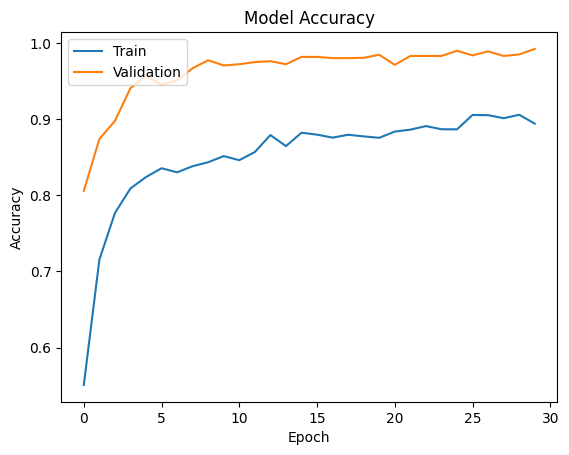

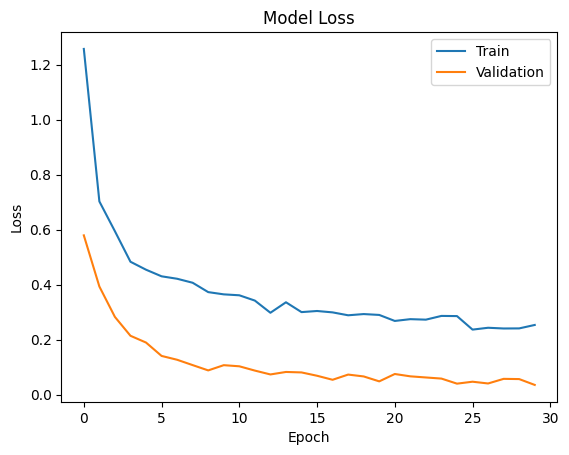

In [ ]:
import matplotlib.pyplot as plt
# 4. Tracer la courbe d'apprentissage
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Étape 5: Sauvegarder le modèle
model.save('/content/drive/MyDrive/ct-kidney/model/final_model.h5')

# Étape 6: Charger le modèle et évaluer les données de test

# Charger le modèle sauvegardé
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ct-kidney/model/final_model.h5')

# Utiliser ImageDataGenerator pour normaliser les données de test
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Charger les données de test à partir du dossier correspondant
test_generator = test_datagen.flow_from_directory(test_folder, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Évaluer le modèle chargé sur les données de test
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 2495 images belonging to 4 classes.
78/78 [==============================] - 34s 426ms/step - loss: 0.0372 - accuracy: 0.9876
Test Loss: 0.037222784012556076
Test Accuracy: 0.9875751733779907


78/78 [==============================] - 27s 345ms/step


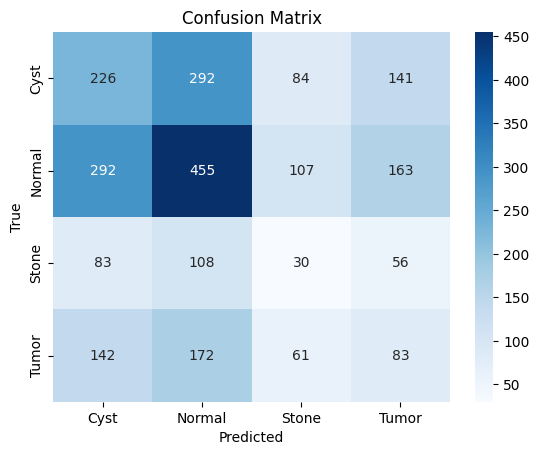

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtenir les prédictions du modèle sur les données de test
y_pred = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convertir les prédictions en classes prédites

# Obtenir les vraies classes des données de test
y_true = test_generator.classes

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion sous forme de graphique
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Chemin vers la photo à prédire
image_path = "/content/drive/MyDrive/ct-kidney/Stone- (84).jpg"  # Remplacez par le chemin de votre image

# Charger l'image et la redimensionner aux dimensions attendues par le modèle
img = image.load_img(image_path, target_size=(224, 224))

# Prétraiter l'image pour la passer au modèle
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.0

# Faire la prédiction
predictions = loaded_model.predict(img)

# Obtenir les noms des classes
class_names = train_generator.class_indices

# Afficher les probabilités pour chaque classe
for class_name, prob in zip(class_names, predictions[0]):
    print(f"{class_name}: {prob}")


1/1 [==============================] - 0s 43ms/step
Cyst: 0.0008057526429183781
Normal: 1.1138651778708208e-08
Stone: 0.9991942048072815
Tumor: 2.5332578257319938e-09
